In [4]:
pip install optuna tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 17.4 MB/s eta 0:00:00


/tmp/ipython-input-886866400.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fe['very_frequent_claimer'] = (df_fe['past_num_of_claims'] > 10).astype(int)
/tmp/ipython-input-886866400.py:187: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fe['large_payout'] = (df_fe['claim_est_payout'] > 5000).astype(int)
/tmp/ipython-input-886866400.py:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-11-09 22:53:30,203] Trial 0 finished with value: 0.5835487428242375 and parameters: {'learning_rate': 0.031133692177715687, 'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.1414832441886485, 'subsample': 0.7055166999250575, 'colsample_bytree': 0.6397594833471179, 'reg_alpha': 0.06837429317224347, 'reg_lambda': 1.4012912465498215, 'scale_pos_weight': 4.036496947735442}. Best is trial 0 with value: 0.5835487428242375.
[I 2025-11-09 22:54:23,049] Trial 1 finished with value: 0.5717100438943216 and parameters: {'learning_rate': 0.06567311998377795, 'max_depth': 4, 'min_child_weight': 5, 'gamma': 0.16065037485381436, 'subsample': 0.6502882382253464, 'colsample_bytree': 0.7072921258321568, 'reg_alpha': 0.273295907962498, 'reg_lambda': 1.4157116517685004, 'scale_pos_weight': 5.612529827095189}. Best is trial 0 with value: 0.5835487428242375.
[I 2025-11-09 22:55:12,540] Trial 2 finished with value: 0.5825963857457094 and parameters: {'learning_rate': 0.03649509929049954, 'max_depth': 

/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Before calibration - Best F1: 0.5963
After calibration  - Best F1: 0.5963
Best threshold = 0.321, Best F1 = 0.5963
ROC AUC: 0.8358241758241758
PR AUC: 0.6031171337434642


/tmp/ipython-input-886866400.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fe['very_frequent_claimer'] = (df_fe['past_num_of_claims'] > 10).astype(int)
/tmp/ipython-input-886866400.py:187: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fe['large_payout'] = (df_fe['claim_est_payout'] > 5000).astype(int)
/tmp/ipython-input-886866400.py:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

   claim_number  subrogation
0       3126034            0
1       7380142            1
2       4655051            0
3       6728725            1
4       9848460            1


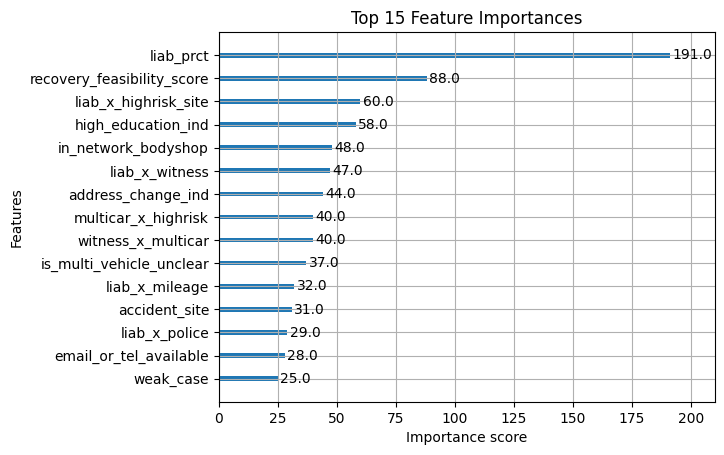

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
import optuna
import matplotlib.pyplot as plt
import xgboost as xgb

# ================================
# 1. 加载数据
# ================================
df = pd.read_csv("/content/drive/MyDrive/model-citizens/data/Training_TriGuard.csv")
df = df.dropna(subset=['subrogation'])

train, test = train_test_split(df, test_size=0.3, random_state=12, stratify=df['subrogation'])
X_train = train.drop(columns=["subrogation"]).copy()
y_train = train["subrogation"].copy()
X_test = test.drop(columns=["subrogation"]).copy()
y_test = test["subrogation"].copy()

real_test = pd.read_csv("/content/drive/MyDrive/model-citizens/data/Testing_TriGuard.csv")

# ================================
# 2. 特征工程函数
# ================================
def feature_engineer(df):
    """Feature engineering WITHOUT vehicle_made_year/vehicle_age (data quality issues)"""
    df_fe = df.copy()

    # ========================================================================
    # TEMPORAL FEATURES
    # ========================================================================
    df_fe['claim_date'] = pd.to_datetime(df_fe['claim_date'], errors='coerce')
    df_fe['claim_year'] = df_fe['claim_date'].dt.year
    df_fe['claim_month'] = df_fe['claim_date'].dt.month
    df_fe['claim_day'] = df_fe['claim_date'].dt.day
    df_fe['claim_quarter'] = df_fe['claim_date'].dt.quarter
    df_fe['claim_dayofweek'] = df_fe['claim_date'].dt.dayofweek
    df_fe['is_weekend'] = (df_fe['claim_dayofweek'] >= 5).astype(int)
    df_fe['is_monday'] = (df_fe['claim_dayofweek'] == 0).astype(int)
    df_fe['is_friday'] = (df_fe['claim_dayofweek'] == 4).astype(int)
    df_fe['is_q4'] = (df_fe['claim_quarter'] == 4).astype(int)

    season_map = {
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Fall', 10: 'Fall', 11: 'Fall',
        12: 'Winter', 1: 'Winter', 2: 'Winter'
    }
    df_fe['season'] = df_fe['claim_month'].map(season_map).fillna('Unknown')


    # ========================================================================
    # BINARY CONVERSIONS (for interactions)
    # ========================================================================
    df_fe['witness_binary'] = (df_fe['witness_present_ind'] == 'Y').astype(int)
    df_fe['police_binary'] = df_fe['policy_report_filed_ind']
    df_fe['multicar_binary'] = df_fe['accident_type'].isin(['multi_vehicle_clear', 'multi_vehicle_unclear']).astype(int)
    df_fe['highrisk_site_binary'] = df_fe['accident_site'].isin(['Highway/Intersection', 'Local']).astype(int)

    # ========================================================================
    # CRITICAL INTERACTION FEATURES (2-way)
    # ========================================================================
    df_fe['liab_x_witness'] = df_fe['liab_prct'] * df_fe['witness_binary']
    df_fe['liab_x_police'] = df_fe['liab_prct'] * df_fe['police_binary']
    df_fe['liab_x_multicar'] = df_fe['liab_prct'] * df_fe['multicar_binary']
    df_fe['liab_x_highrisk_site'] = df_fe['liab_prct'] * df_fe['highrisk_site_binary']
    df_fe['liab_x_evidence'] = df_fe['liab_prct'] * (df_fe['witness_binary'] + df_fe['police_binary'])
    df_fe['liab_x_payout'] = df_fe['liab_prct'] * df_fe['claim_est_payout']
    df_fe['liab_x_mileage'] = df_fe['liab_prct'] * df_fe['vehicle_mileage']
    df_fe['witness_x_police'] = df_fe['witness_binary'] * df_fe['police_binary']
    df_fe['witness_x_multicar'] = df_fe['witness_binary'] * df_fe['multicar_binary']
    df_fe['police_x_multicar'] = df_fe['police_binary'] * df_fe['multicar_binary']
    df_fe['multicar_x_highrisk'] = df_fe['multicar_binary'] * df_fe['highrisk_site_binary']
    df_fe['weekend_highway'] = (df_fe['claim_dayofweek'] >= 5).astype(int) * (df_fe['accident_site'] == 'Highway/Intersection').astype(int)
    df_fe['witness_police_multicar'] = df_fe['witness_binary'] * df_fe['police_binary'] * df_fe['multicar_binary']

    # ========================================================================
    # POLYNOMIAL FEATURES (liability & key variables)
    # ========================================================================
    df_fe['liab_prct_squared'] = df_fe['liab_prct'] ** 2
    df_fe['liab_prct_cubed'] = df_fe['liab_prct'] ** 3
    df_fe['liab_prct_sqrt'] = np.sqrt(df_fe['liab_prct'])
    df_fe['liab_prct_log'] = np.log1p(df_fe['liab_prct'])
    df_fe['liab_inverse'] = 100 - df_fe['liab_prct']
    df_fe['liab_inverse_squared'] = (100 - df_fe['liab_prct']) ** 2
    df_fe['log_claim_est_payout'] = np.log1p(df_fe['claim_est_payout'])
    df_fe['log_vehicle_mileage'] = np.log1p(df_fe['vehicle_mileage'])
    df_fe['log_vehicle_price'] = np.log1p(df_fe['vehicle_price'])
    df_fe['log_annual_income'] = np.log1p(df_fe['annual_income'])
    df_fe['sqrt_vehicle_mileage'] = np.sqrt(df_fe['vehicle_mileage'])

    # ========================================================================
    # ACCIDENT TYPE FEATURES
    # ========================================================================
    df_fe['is_multi_vehicle_clear'] = (df_fe['accident_type'] == 'multi_vehicle_clear').astype(int)
    df_fe['is_multi_vehicle_unclear'] = (df_fe['accident_type'] == 'multi_vehicle_unclear').astype(int)
    df_fe['is_single_car'] = (df_fe['accident_type'] == 'single_car').astype(int)
    df_fe['has_recovery_target'] = df_fe['multicar_binary']
    df_fe['recovery_case_clarity'] = 0
    df_fe.loc[df_fe['is_multi_vehicle_clear'] == 1, 'recovery_case_clarity'] = 3
    df_fe.loc[df_fe['is_multi_vehicle_unclear'] == 1, 'recovery_case_clarity'] = 1

    # ========================================================================
    # LIABILITY BUCKETS (fine-grained)
    # ========================================================================
    df_fe['liab_under_10'] = (df_fe['liab_prct'] < 10).astype(int)
    df_fe['liab_10_to_15'] = ((df_fe['liab_prct'] >= 10) & (df_fe['liab_prct'] < 15)).astype(int)
    df_fe['liab_15_to_20'] = ((df_fe['liab_prct'] >= 15) & (df_fe['liab_prct'] < 20)).astype(int)
    df_fe['liab_20_to_25'] = ((df_fe['liab_prct'] >= 20) & (df_fe['liab_prct'] < 25)).astype(int)
    df_fe['liab_25_to_30'] = ((df_fe['liab_prct'] >= 25) & (df_fe['liab_prct'] < 30)).astype(int)
    df_fe['liab_30_to_35'] = ((df_fe['liab_prct'] >= 30) & (df_fe['liab_prct'] < 35)).astype(int)
    df_fe['liab_35_to_40'] = ((df_fe['liab_prct'] >= 35) & (df_fe['liab_prct'] < 40)).astype(int)
    df_fe['liab_40_to_50'] = ((df_fe['liab_prct'] >= 40) & (df_fe['liab_prct'] < 50)).astype(int)
    df_fe['liab_over_50'] = (df_fe['liab_prct'] >= 50).astype(int)
    df_fe['not_at_fault'] = df_fe['liab_under_10']
    df_fe['minimal_fault'] = (df_fe['liab_prct'] < 25).astype(int)
    df_fe['low_fault'] = (df_fe['liab_prct'] < 35).astype(int)
    df_fe['shared_fault'] = ((df_fe['liab_prct'] >= 35) & (df_fe['liab_prct'] < 50)).astype(int)
    df_fe['high_fault'] = (df_fe['liab_prct'] >= 50).astype(int)

    # ========================================================================
    # EVIDENCE QUALITY FEATURES
    # ========================================================================
    df_fe['witness_present'] = df_fe['witness_binary']
    df_fe['police_report'] = df_fe['police_binary']
    df_fe['evidence_none'] = ((df_fe['witness_present'] == 0) & (df_fe['police_report'] == 0)).astype(int)
    df_fe['evidence_weak'] = (((df_fe['witness_present'] == 1) & (df_fe['police_report'] == 0)) |
                              ((df_fe['witness_present'] == 0) & (df_fe['police_report'] == 1))).astype(int)
    df_fe['evidence_strong'] = ((df_fe['witness_present'] == 1) & (df_fe['police_report'] == 1)).astype(int)
    df_fe['evidence_very_strong'] = ((df_fe['witness_present'] == 1) & (df_fe['police_report'] == 1) &
                                     (df_fe['liab_prct'] < 20)).astype(int)
    df_fe['evidence_score'] = df_fe['witness_present'] + df_fe['police_report']

        # ========================================================================
    # ACCIDENT SITE FEATURES
    # ========================================================================
    df_fe['high_risk_site'] = df_fe['highrisk_site_binary']
    df_fe['parking_accident'] = (df_fe['accident_site'] == 'Parking Area').astype(int)
    df_fe['unknown_site'] = (df_fe['accident_site'] == 'Unknown').astype(int)
    df_fe['highway_accident'] = (df_fe['accident_site'] == 'Highway/Intersection').astype(int)
    df_fe['local_accident'] = (df_fe['accident_site'] == 'Local').astype(int)

    # ========================================================================
    # DRIVER AGE & EXPERIENCE
    # ========================================================================
    df_fe['driver_age'] = df_fe['claim_year'] - df_fe['year_of_born']
    df_fe.loc[(df_fe['driver_age'] < 16) | (df_fe['driver_age'] > 100), 'driver_age'] = np.nan
    df_fe['young_driver'] = ((df_fe['driver_age'] >= 16) & (df_fe['driver_age'] <= 25)).astype(int)
    df_fe['prime_driver'] = ((df_fe['driver_age'] > 25) & (df_fe['driver_age'] <= 45)).astype(int)
    df_fe['middle_age_driver'] = ((df_fe['driver_age'] > 45) & (df_fe['driver_age'] <= 65)).astype(int)
    df_fe['senior_driver'] = (df_fe['driver_age'] > 65).astype(int)
    df_fe['driving_experience'] = (df_fe['driver_age'] - df_fe['age_of_DL']).clip(lower=0)
    df_fe.loc[df_fe['driving_experience'] < 0, 'driving_experience'] = np.nan
    df_fe['novice_driver'] = (df_fe['driving_experience'] < 3).astype(int)
    df_fe['experienced_driver'] = ((df_fe['driving_experience'] >= 3) & (df_fe['driving_experience'] <= 10)).astype(int)
    df_fe['veteran_driver'] = (df_fe['driving_experience'] > 10).astype(int)
    df_fe['experience_x_safety'] = df_fe['driving_experience'] * df_fe['safety_rating']
    df_fe['driver_age_x_safety'] = df_fe['driver_age'] * df_fe['safety_rating']

    # ========================================================================
    # VEHICLE FEATURES (without vehicle_age)
    # ========================================================================
    df_fe['luxury_vehicle'] = (df_fe['vehicle_price'] > 50000).astype(int)
    df_fe['mid_price_vehicle'] = ((df_fe['vehicle_price'] >= 20000) & (df_fe['vehicle_price'] <= 50000)).astype(int)
    df_fe['economy_vehicle'] = (df_fe['vehicle_price'] < 20000).astype(int)
    df_fe['heavy_vehicle'] = (df_fe['vehicle_weight'] > 30000).astype(int)
    df_fe['light_vehicle'] = (df_fe['vehicle_weight'] < 15000).astype(int)
    df_fe['medium_weight'] = ((df_fe['vehicle_weight'] >= 15000) & (df_fe['vehicle_weight'] <= 30000)).astype(int)
    df_fe['is_large_vehicle'] = (df_fe['vehicle_category'] == 'Large').astype(int)
    df_fe['is_compact_vehicle'] = (df_fe['vehicle_category'] == 'Compact').astype(int)
    df_fe['is_medium_vehicle'] = (df_fe['vehicle_category'] == 'Medium').astype(int)

    # ========================================================================
    # CLAIM CHARACTERISTICS
    # ========================================================================
    df_fe['high_mileage'] = (df_fe['vehicle_mileage'] > 100000).astype(int)
    df_fe['low_mileage'] = (df_fe['vehicle_mileage'] < 50000).astype(int)
    df_fe['very_high_mileage'] = (df_fe['vehicle_mileage'] > 150000).astype(int)
    df_fe['medium_mileage'] = ((df_fe['vehicle_mileage'] >= 50000) & (df_fe['vehicle_mileage'] <= 100000)).astype(int)
    df_fe['frequent_claimer'] = (df_fe['past_num_of_claims'] > 5).astype(int)
    df_fe['moderate_claimer'] = ((df_fe['past_num_of_claims'] >= 1) & (df_fe['past_num_of_claims'] <= 5)).astype(int)
    df_fe['first_time_claimer'] = (df_fe['past_num_of_claims'] == 0).astype(int)
    df_fe['very_frequent_claimer'] = (df_fe['past_num_of_claims'] > 10).astype(int)
    df_fe['large_payout'] = (df_fe['claim_est_payout'] > 5000).astype(int)
    df_fe['medium_payout'] = ((df_fe['claim_est_payout'] >= 2000) & (df_fe['claim_est_payout'] <= 5000)).astype(int)
    df_fe['small_payout'] = (df_fe['claim_est_payout'] < 2000).astype(int)
    df_fe['very_large_payout'] = (df_fe['claim_est_payout'] > 8000).astype(int)
    df_fe['safety_x_prior_claims'] = df_fe['safety_rating'] / (1 + df_fe['past_num_of_claims'])
    df_fe['mileage_x_claims'] = df_fe['vehicle_mileage'] * df_fe['past_num_of_claims']

    # ========================================================================
    # RATIO FEATURES
    # ========================================================================
    df_fe['payout_to_price_ratio'] = df_fe['claim_est_payout'] / (df_fe['vehicle_price'] + 1)
    df_fe['severe_damage'] = (df_fe['payout_to_price_ratio'] > 0.3).astype(int)
    df_fe['moderate_damage'] = ((df_fe['payout_to_price_ratio'] >= 0.1) & (df_fe['payout_to_price_ratio'] <= 0.3)).astype(int)
    df_fe['minor_damage'] = (df_fe['payout_to_price_ratio'] < 0.1).astype(int)
    df_fe['income_to_vehicle_price'] = df_fe['annual_income'] / (df_fe['vehicle_price'] + 1)
    df_fe['can_afford_vehicle'] = (df_fe['income_to_vehicle_price'] >= 0.5).astype(int)
    df_fe['expensive_for_income'] = (df_fe['income_to_vehicle_price'] < 0.3).astype(int)
    df_fe['claims_per_year_driving'] = df_fe['past_num_of_claims'] / (df_fe['driving_experience'] + 1)
    df_fe['claim_frequency_high'] = (df_fe['claims_per_year_driving'] > 0.5).astype(int)
    df_fe['safety_to_liability'] = df_fe['safety_rating'] / (df_fe['liab_prct'] + 1)
    df_fe['payout_to_income'] = df_fe['claim_est_payout'] / (df_fe['annual_income'] + 1)
    df_fe['mileage_to_price'] = df_fe['vehicle_mileage'] / (df_fe['vehicle_price'] + 1)
    df_fe['weight_to_price'] = df_fe['vehicle_weight'] / (df_fe['vehicle_price'] + 1)

    # ========================================================================
    # POLICYHOLDER CHARACTERISTICS
    # ========================================================================
    df_fe['high_income'] = (df_fe['annual_income'] > 70000).astype(int)
    df_fe['mid_income'] = ((df_fe['annual_income'] >= 40000) & (df_fe['annual_income'] <= 70000)).astype(int)
    df_fe['low_income'] = (df_fe['annual_income'] < 40000).astype(int)
    df_fe['very_high_income'] = (df_fe['annual_income'] > 100000).astype(int)
    df_fe['high_safety_rating'] = (df_fe['safety_rating'] > 80).astype(int)
    df_fe['low_safety_rating'] = (df_fe['safety_rating'] < 60).astype(int)
    df_fe['very_high_safety'] = (df_fe['safety_rating'] > 90).astype(int)
    df_fe['medium_safety'] = ((df_fe['safety_rating'] >= 60) & (df_fe['safety_rating'] <= 80)).astype(int)
    df_fe['contact_available'] = df_fe['email_or_tel_available']
    df_fe['has_education'] = df_fe['high_education_ind']
    df_fe['recent_move'] = df_fe['address_change_ind']
    df_fe['home_owner'] = (df_fe['living_status'] == 'Own').astype(int)
    df_fe['renter'] = (df_fe['living_status'] == 'Rent').astype(int)
    df_fe['female'] = (df_fe['gender'] == 'F').astype(int)

    # ========================================================================
    # CHANNEL FEATURES
    # ========================================================================
    df_fe['via_broker'] = (df_fe['channel'] == 'Broker').astype(int)
    df_fe['via_online'] = (df_fe['channel'] == 'Online').astype(int)
    df_fe['via_phone'] = (df_fe['channel'] == 'Phone').astype(int)
    df_fe['in_network_repair'] = (df_fe['in_network_bodyshop'] == 'yes').astype(int)
    df_fe['out_network_repair'] = (df_fe['in_network_bodyshop'] == 'no').astype(int)

    # ========================================================================
    # COMPOSITE RECOVERY SCORE
    # ========================================================================
    liability_score = np.sqrt((100 - df_fe['liab_prct']) / 100.0)
    evidence_score = (df_fe['evidence_none'] * 0.0 +
                      df_fe['evidence_weak'] * 0.4 +
                      df_fe['evidence_strong'] * 0.7 +
                      df_fe['evidence_very_strong'] * 1.0)
    clarity_score = df_fe['recovery_case_clarity'] / 3.0
    site_score = df_fe['high_risk_site'] * 0.7 + (1 - df_fe['unknown_site']) * 0.3
    df_fe['recovery_feasibility_score'] = (
        0.35 * liability_score +
        0.30 * df_fe['has_recovery_target'] +
        0.20 * evidence_score +
        0.10 * clarity_score +
        0.05 * site_score
    )

    # ========================================================================
    # DOMAIN LOGIC FLAGS (CRITICAL FOR F1)
    # ========================================================================
    df_fe['perfect_case'] = ((df_fe['liab_prct'] < 15) & (df_fe['witness_present'] == 1) &
                             (df_fe['police_report'] == 1) & (df_fe['has_recovery_target'] == 1)).astype(int)
    df_fe['strong_case'] = ((df_fe['liab_prct'] < 25) & (df_fe['evidence_strong'] == 1) &
                            (df_fe['has_recovery_target'] == 1)).astype(int)
    df_fe['good_case'] = ((df_fe['liab_prct'] < 35) & (df_fe['evidence_score'] >= 1) &
                          (df_fe['has_recovery_target'] == 1)).astype(int)
    df_fe['weak_case'] = ((df_fe['liab_prct'] > 40) | (df_fe['is_single_car'] == 1) |
                          (df_fe['evidence_none'] == 1)).astype(int)
    df_fe['no_case'] = ((df_fe['liab_prct'] > 60) | ((df_fe['is_single_car'] == 1) &
                        (df_fe['evidence_none'] == 1))).astype(int)
    df_fe['high_value_opportunity'] = ((df_fe['claim_est_payout'] > 3000) &
                                       (df_fe['liab_prct'] < 30) &
                                       (df_fe['has_recovery_target'] == 1)).astype(int)
    df_fe['slam_dunk_case'] = ((df_fe['liab_prct'] < 10) & (df_fe['witness_present'] == 1) &
                               (df_fe['police_report'] == 1) & (df_fe['multicar_binary'] == 1) &
                               (df_fe['high_risk_site'] == 1)).astype(int)
    df_fe['low_liab_high_payout'] = ((df_fe['liab_prct'] < 20) & (df_fe['claim_est_payout'] > 5000)).astype(int)
    df_fe['clear_fault_case'] = ((df_fe['liab_prct'] < 15) & (df_fe['multicar_binary'] == 1)).astype(int)
    df_fe['high_mileage_low_fault'] = ((df_fe['vehicle_mileage'] > 100000) &
                                       (df_fe['liab_prct'] < 30)).astype(int)

    # --- Temporal & Behavior Dynamics ---
    df_fe['claim_early_in_year'] = (df_fe['claim_month'] <= 3).astype(int)
    df_fe['claim_end_of_year'] = (df_fe['claim_month'] >= 10).astype(int)
    df_fe['weekend_parking'] = df_fe['is_weekend'] * (df_fe['accident_site'] == 'Parking Area').astype(int)
    df_fe['winter_claim_high_payout'] = ((df_fe['season'] == 'Winter') &
                                         (df_fe['claim_est_payout'] > 5000)).astype(int)

    # --- Vehicle Utilization Proxies ---
    df_fe['mileage_x_weight'] = df_fe['vehicle_mileage'] * df_fe['vehicle_weight']
    df_fe['mileage_per_dollar'] = df_fe['vehicle_mileage'] / (df_fe['vehicle_price'] + 1)
    df_fe['payout_to_weight'] = df_fe['claim_est_payout'] / (df_fe['vehicle_weight'] + 1)

    # --- Policyholder Risk Profile ---
    df_fe['unstable_policyholder'] = ((df_fe['recent_move'] == 1) & (df_fe['renter'] == 1)).astype(int)
    df_fe['financial_stress_risk'] = ((df_fe['expensive_for_income'] == 1) &
                                      (df_fe['large_payout'] == 1)).astype(int)
    df_fe['young_driver_highway'] = df_fe['young_driver'] * df_fe['highway_accident']
    df_fe['senior_driver_parking'] = df_fe['senior_driver'] * df_fe['parking_accident']

    # --- Liability & Evidence Interaction Insights ---
    df_fe['low_liab_weak_evidence'] = ((df_fe['liab_prct'] < 20) &
                                       (df_fe['evidence_weak'] == 1)).astype(int)
    df_fe['high_liab_strong_evidence'] = ((df_fe['liab_prct'] > 50) &
                                          (df_fe['evidence_strong'] == 1)).astype(int)

    # --- Composite confidence / case quality index ---
    df_fe['case_confidence_score'] = (
        0.4 * (100 - df_fe['liab_prct']) / 100 +
        0.4 * df_fe['evidence_score'] / 2 +
        0.2 * df_fe['recovery_case_clarity'] / 3
    )

    # --- Statistical Normalization & Percentile Features ---
    for col in ['claim_est_payout', 'vehicle_mileage', 'annual_income']:
        df_fe[f'{col}_z'] = (df_fe[col] - df_fe[col].mean()) / (df_fe[col].std() + 1e-9)

    try:
        df_fe['liab_percentile'] = pd.qcut(df_fe['liab_prct'], 10, labels=False, duplicates='drop')
        df_fe['payout_percentile'] = pd.qcut(df_fe['claim_est_payout'], 10, labels=False, duplicates='drop')
    except Exception:
        df_fe['liab_percentile'] = np.nan
        df_fe['payout_percentile'] = np.nan

    # --- Aggregate / Hybrid Indices ---
    df_fe['case_strength_index'] = df_fe['evidence_score'] * (1 - df_fe['liab_prct'] / 100)
    df_fe['financial_exposure_index'] = (
        (df_fe['claim_est_payout'] / (df_fe['annual_income'] + 1)) *
        (1 + df_fe['liab_prct'] / 100)
    )
    df_fe['behavioral_risk_index'] = (
        df_fe['claims_per_year_driving'] * (100 - df_fe['safety_rating']) / 100
    )

    return df_fe



# ================================
# 3. 预处理类
# ================================
class Preprocessor:
    def __init__(self):
        self.id_column = ['claim_number']
        self.min_driver_age = 14
        self.max_driver_age = 120
        self.categorical_cols_ = None
        self.label_encoders = {}
        self.income_q25 = None
        self.income_q75 = None

    def _coerce_and_clean(self, df):
        df = df.copy()
        df['claim_date'] = pd.to_datetime(df['claim_date'], errors='coerce')
        df['claim_year'] = df['claim_date'].dt.year
        future_mask = df['vehicle_made_year'] > df['claim_year']
        df.loc[future_mask, 'vehicle_made_year'] = np.nan
        return df

    def fit(self, df):
        df = self._coerce_and_clean(df.copy())
        self.income_q25 = df['annual_income'].quantile(0.25)
        self.income_q75 = df['annual_income'].quantile(0.75)
        df = feature_engineer(df)
        self.categorical_cols_ = list(df.select_dtypes(include=['object']).columns)
        self.label_encoders.clear()
        for col in self.categorical_cols_:
            le = LabelEncoder()
            le.fit(df[col].astype(str))
            self.label_encoders[col] = le
        return self

    def transform(self, df):
        df = self._coerce_and_clean(df.copy())
        df = feature_engineer(df)
        q25, q75 = self.income_q25, self.income_q75
        df['low_income'] = (df['annual_income'] <= q25).astype(int)
        df['middle_income'] = ((df['annual_income'] > q25) & (df['annual_income'] <= q75)).astype(int)
        df['high_income'] = (df['annual_income'] > q75).astype(int)
        for col, le in self.label_encoders.items():
            df[col] = le.transform(df[col].astype(str))
        df = df.drop(columns=['claim_date'], errors='ignore')
        return df

    def fit_transform(self, df):
        return self.fit(df).transform(df)

# ================================
# 4. 数据预处理
# ================================
pre = Preprocessor()
X_train_proc = pre.fit_transform(X_train)
X_test_proc = pre.transform(X_test)
X_test_proc = X_test_proc.reindex(columns=X_train_proc.columns, fill_value=0)

# ================================
# 5. Optuna 超参数优化
# ================================
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

def objective(trial):
    params = {
        "n_estimators": 1200,
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
        "gamma": trial.suggest_float("gamma", 0.05, 0.5),
        "subsample": trial.suggest_float("subsample", 0.6, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.9),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 0.5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.8, 1.5),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", ratio * 0.8, ratio * 2.0),
        "random_state": 12,
        "eval_metric": "auc",
        "n_jobs": -1,
    }

    model = XGBClassifier(**params)
    model.fit(
        X_train_proc, y_train,
        eval_set=[(X_test_proc, y_test)],
        #early_stopping_rounds=50,
        verbose=False,
    )

    preds = model.predict_proba(X_test_proc)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, preds)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
    best_f1 = np.nanmax(f1_scores)
    return best_f1

# ================================
# 6. 运行调参
# ================================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=60, show_progress_bar=True)

print("最优参数:", study.best_params)
print(f"最优 F1 值: {study.best_value:.4f}")

# ================================
# 7. 用最优参数训练模型 + 概率校准
# ================================
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score

# Step 7.1: 在训练集中再划分一部分用于校准
X_train_sub, X_cal, y_train_sub, y_cal = train_test_split(
    X_train_proc, y_train, test_size=0.2, random_state=12, stratify=y_train
)

# Step 7.2: 用子训练集训练模型
best_model = XGBClassifier(**study.best_params)
best_model.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_cal, y_cal)],
    verbose=False
)

# Step 7.3: 先计算未校准的 F1
preds_before = best_model.predict_proba(X_test_proc)[:, 1]
precisions_b, recalls_b, thresholds_b = precision_recall_curve(y_test, preds_before)
f1_scores_b = 2 * (precisions_b * recalls_b) / (precisions_b + recalls_b + 1e-6)
f1_before = np.nanmax(f1_scores_b)

# Step 7.4: 概率校准 (Platt scaling)
calibrated_model = CalibratedClassifierCV(best_model, cv='prefit', method='sigmoid')
calibrated_model.fit(X_cal, y_cal)

# Step 7.5: 校准后再计算 F1
preds_after = calibrated_model.predict_proba(X_test_proc)[:, 1]
precisions_a, recalls_a, thresholds_a = precision_recall_curve(y_test, preds_after)
f1_scores_a = 2 * (precisions_a * recalls_a) / (precisions_a + recalls_a + 1e-6)
f1_after = np.nanmax(f1_scores_a)

print(f"Before calibration - Best F1: {f1_before:.4f}")
print(f"After calibration  - Best F1: {f1_after:.4f}")


# ================================
# 8. 最优阈值搜索
# ================================
preds = calibrated_model.predict_proba(X_test_proc)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, preds)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.nanmax(f1_scores)

print(f"Best threshold = {best_threshold:.3f}, Best F1 = {best_f1:.4f}")
print("ROC AUC:", roc_auc_score(y_test, preds))
print("PR AUC:", average_precision_score(y_test, preds))

# ================================
# 9. 对真实测试集预测
# ================================
X_real_test_proc = pre.transform(real_test)
X_real_test_proc = X_real_test_proc.reindex(columns=X_train_proc.columns, fill_value=0)

real_pred_proba = calibrated_model.predict_proba(X_real_test_proc)[:, 1]
real_pred_label = (real_pred_proba >= best_threshold).astype(int)

prediction = pd.DataFrame({
    "claim_number": real_test["claim_number"],
    "subrogation": real_pred_label
})

prediction.to_csv("TriGuard_9_prediction.csv", index=False)
print(prediction.head())

# ================================
# 10. 可视化特征重要性
# ================================
xgb.plot_importance(best_model, max_num_features=15)
plt.title("Top 15 Feature Importances")
plt.show()
